'''
https://github.com/nbhr/pycalib/blob/master/ipynb/incalib_charuco.ipynb
'''

# Intrinsic Camera Calibration of GoPro with OpenCV ChAruCo pattern

### Goal

The goal of this notebook is to calibrate the intrinsic parameter $K$ of the camera.  Given a number of chessboard (charuco) images, this notebook first detects the corner positions in each image, and then finds the camera pose of each frame and the camera intrinsic parameters.

* Input:  $n$ chessboard images (= the 2D corner position $x$ and the corresponding 3D position $X$ in the world (chessboard) coordinate system)
* Output: intrinsic parameter $K$, distortion coefficients $d$, $n$ camera poses $R_i, t_i$ w.r.t. the chessboard

To have a better / robust estimation of $K$, the chessboard should be captured as large as possible in the DoF in different poses.


Notice:
* The chessboard coordinate system serves as the world coordinate system.
* Though we obtain $R, t$ as a result, we are not interested in them in this scenario.


### Projection model

Please check the OpenCV document for the detail. 
* https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#details

In short, a 3D point $X$ in the world coordinate system (WCS) is transformed to the camera coordinate system (CCS) by a roation $R$ and a translation $t$, and then projected to $x$ by $K$:
\begin{equation}
\tilde{x} \sim K \begin{bmatrix}
R \: | \: t
\end{bmatrix}
\tilde{X}.
\end{equation}


## Libraries

In [1]:
import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)



## Calibration parameters

**Important**
* Compare the pattern shown below with the pattern captured in the image.
* The numbers of rows and cols indicate **the numbers of CELLs, not corners**.
  * For example, an 18x9 ChAruco board has a 18 cells == 17 corners by 9 cells == 8 corners pattern.
  * In the case of the traditional chessboard, the rows and cols indicate the numbers of corners.

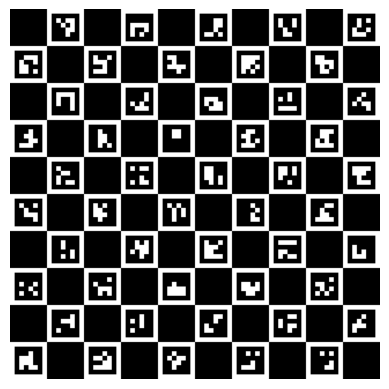

In [2]:
# Chessboard configuration

aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
board = cv2.aruco.CharucoBoard((10, 10), 0.02, 0.015, aruco_dict)

# check if the board is correct
image = board.generateImage((2560, 2560))

# save the image to "aruco_calib.jpg"
cv2.imwrite("aruco_calib.jpg", image)

plt.figure()
plt.imshow(image, cmap='gray')
#plt.title('DICT_4X4_250 6x5 ChAruco pattern')
plt.axis('off')
plt.show()

In [3]:
from xarm6_interface.utils.realsense import Realsense
camera = Realsense()

# import os

# def create_window_and_capture_data(realsense_instance, save_dir='captured_images'):
#     # Ensure the save directory exists
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)
    
#     index = 0  # Initialize the index for saved images
#     while True:
#         # Get the current data from the Realsense instance
#         color_image, depth_image, pointcloud, colored_depth_image = realsense_instance.getCurrentData(mode='rgb+depth+pointcloud+coloredDepth')
        
#         # Display the RGB and colored depth images
#         cv2.imshow('Color Image', cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR))
#         cv2.imshow('Colored Depth Image', colored_depth_image)
        
#         # Wait for a key press
#         key = cv2.waitKey(1) & 0xFF
        
#         # If the space bar is pressed, save the images
#         if key == ord(' '):
#             color_filename = os.path.join(save_dir, f"{index:05d}_color.jpg")

#             # Save the color and depth images
#             cv2.imwrite(color_filename, cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR))
            
#             index += 1
        
#         # Exit on 'q' key press
#         elif key == ord('q'):
#             break

#     # Close all OpenCV windows
#     cv2.destroyAllWindows()
#     realsense_instance.stop()

# # Create a window and capture data
# save_dir = 'intr_captured_images2'
# create_window_and_capture_data(camera, save_dir=save_dir)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2024-09-09 19:33:07.202 | INFO     | xarm6_interface.utils.realsense:__init__:65 - Depth stream: 1280x720 @ 15fps, format.z16
2024-09-09 19:33:07.204 | INFO     | xarm6_interface.utils.realsense:__init__:68 - Color stream: 1280x720 @ 15fps, format.rgb8
2024-09-09 19:33:07.204 | INFO     | xarm6_interface.utils.realsense:__init__:69 - Realsense camera initialized
2024-09-09 19:33:07.284 | INFO     | xarm6_interface.utils.realsense:__init__:87 - Intrinsics: [ 1280x720  p[652.779 358.606]  f[908.167 907.819]  Inverse Brown Conrady [0 0 0 0 0] ]


## 2D corner detection

In [4]:
# Input images capturing the chessboard above
save_dir = "/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib"
input_files = glob(os.path.join(save_dir, '*.png'))
input_files.sort()
input_files

['/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0000.png',
 '/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0001.png',
 '/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0002.png',
 '/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0003.png',
 '/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0004.png',
 '/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0005.png',
 '/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0006.png',
 '/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0007.png',
 '/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0008.png',
 '/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0009.png',
 '/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0010.png',
 '/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0011.png',
 '/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0012.png',
 '/home/aris

/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0000.png  found 80 corners
/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0001.png  found 81 corners
/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0002.png  found 79 corners
/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0003.png  found 79 corners
/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0004.png  found 75 corners
/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0005.png  found 81 corners
/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0006.png  found 81 corners
/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0007.png  found 81 corners
/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0008.png  found 77 corners
/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0009.png  found 79 corners
/home/aris/projects/xarm6/xarm6_interface/utils/rs_calib/color_0010.png  found 75 corners
/home/aris

/tmp/ipykernel_134424/1569340325.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_obj_pts = np.array(all_obj_pts)
/tmp/ipykernel_134424/1569340325.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_img_pts = np.array(all_img_pts)


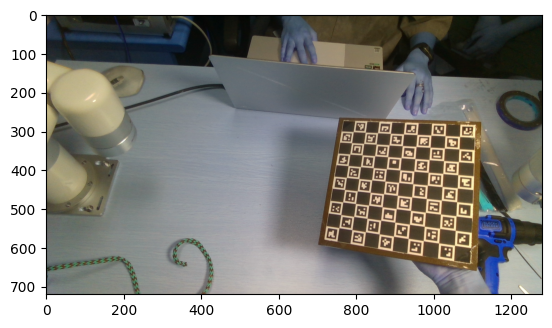

In [5]:
parameters =  cv2.aruco.DetectorParameters()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_CONTOUR
detector = cv2.aruco.CharucoDetector(board, detectorParams=parameters)

all_obj_pts = []
all_img_pts = []
all_ids = []

for i in input_files:
    frame = cv2.imread(i)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    c_corners, c_ids, corners, ids = detector.detectBoard(gray)
    ret = len(c_corners)
    print(f'{i}  found {ret} corners')
    if ret > 0:
        objPoints, imgPoints = board.matchImagePoints(c_corners, c_ids)
        all_obj_pts.append(objPoints)
        all_img_pts.append(imgPoints)
        all_ids.append(c_ids)

    imsize = (gray.shape[1], gray.shape[0])

all_obj_pts = np.array(all_obj_pts)
all_img_pts = np.array(all_img_pts)

print(all_obj_pts.shape, all_img_pts.shape)

# show sample image
plt.figure()
plt.imshow(frame)
plt.show()

## Calibration

In [6]:
#ret, K, d, rvec, tvec = cv2.aruco.calibrateCameraCharuco(all_corners, all_ids, board, imsize, None, None,
#                                                         flags=cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_RATIONAL_MODEL)

ret, K, d, rvec, tvec = cv2.calibrateCamera(all_obj_pts, all_img_pts, imsize, None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_RATIONAL_MODEL)

# save K 
np.save('K_2.npy', K)
np.save('d_2.npy', d)

print("Image size = ", imsize)
print("Reprojection error = ", ret)
print("Intrinsic parameter K = ", K)
print("Distortion parameters d = (k1, k2, p1, p2, k3, k4, k5, k6) = ", d)

assert ret < 1.0


Image size =  (1280, 720)
Reprojection error =  0.2860880091951851
Intrinsic parameter K =  [[918.58304694   0.         648.56418045]
 [  0.         918.58304694 348.43171439]
 [  0.           0.           1.        ]]
Distortion parameters d = (k1, k2, p1, p2, k3, k4, k5, k6) =  [[-1.94085169e+00  5.53280714e+01  5.86518397e-04 -8.65951189e-04
   1.90798751e+02 -1.90855976e+00  5.39381037e+01  1.91094448e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [7]:
original_camera_matrix = camera.K
original_camera_matrix

array([[908.16674805,   0.        , 652.77856445],
       [  0.        , 907.8190918 , 358.60614014],
       [  0.        ,   0.        ,   1.        ]])